In [510]:
import bs4 as bs
import requests
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')

In [109]:
def collectRaw(year):
    print ("Collecting season stats of {}".format(str(year)))
    url = 'https://www.basketball-reference.com/leagues/NBA_{}.html#all_opponent-stats-per_game'.format(str(year))
    raw_source = requests.get(url).text
    source = raw_source.replace("<!--", "")
    
    return source

In [231]:
def parseTable(source, table_name):
    print ("Parsing information of {}".format(str(table_name)))
    soup = bs.BeautifulSoup(source,'html')
    table = soup.find('table', attrs={'id': table_name})
    table_rows = table.find_all('tr')

    th = table.find_all("th", {"scope" : "col"})
    headers = []
    for header in th:
        header = header.text
        if header != "Rk":
            headers.append(header)

    l = []
    for tr in table_rows:
        td = tr.find_all('td')
        row = [tr.text for tr in td]
        l.append(row)
    return pd.DataFrame(l, columns=headers).dropna()
    

In [299]:
table_names = ["team-stats-per_game", "opponent-stats-per_game", "team-stats-base", \
                   "opponent-stats-base", "team-stats-per_poss", "opponent-stats-per_poss"]
source = collectRaw(2016)
TSPG = parseTable(source, table_names[0]).drop(31)
OSPG = parseTable(source, table_names[1]).drop(31)
#TSB = parseTable(source, table_names[2])
#OSB = parseTable(source, table_names[3])
TSPP = parseTable(source, table_names[4])
OSPP = parseTable(source, table_names[5])

Parsing information of team-stats-per_game
Parsing information of opponent-stats-per_game
Parsing information of team-stats-per_poss
Parsing information of opponent-stats-per_poss


In [300]:
pca = PCA(n_components=6)
pca.fit(TSPG[list(TSPG)[2:]])
#pca.explained_variance_ratio_
TSPG_trans = pca.fit_transform(TSPG[list(TSPG)[2:]])

In [301]:
pca = PCA(n_components=6)
pca.fit(OSPG[list(TSPG)[2:]])
#pca.explained_variance_ratio_
OSPG_trans = pca.fit_transform(OSPG[list(OSPG)[2:]])

In [302]:
pca = PCA(n_components=1)
pca.fit(TSPP[list(TSPG)[2:]])
#pca.explained_variance_ratio_
TSPP_trans = pca.fit_transform(TSPP[list(TSPP)[2:]])

In [303]:
pca = PCA(n_components=1)
pca.fit(OSPP[list(OSPG)[2:]])
#pca.explained_variance_ratio_
OSPP_trans = pca.fit_transform(OSPP[list(OSPP)[2:]])

In [304]:
data_trans = np.append(TSPG_trans, OSPG_trans, 1)
data_trans = np.append(data_trans, TSPP_trans, 1)
data_trans = np.append(data_trans, OSPP_trans, 1)

In [305]:
for i in xrange(14):
    
    data_trans[:,i] = (data_trans[:,i] - data_trans[:,i].mean())/data_trans[:,i].std()

data_trans = pd.DataFrame(data_trans, columns= ["TSPG_0", "TSPG_1", "TSPG_2", "TSPG_3", "TSPG_4", "TSPG_5", \
                                               "OSPG_0", "OSPG_1", "OSPG_2", "OSPG_3", "OSPG_4", "OSPG_5", \
                                               "TSPP", "OSPP"])

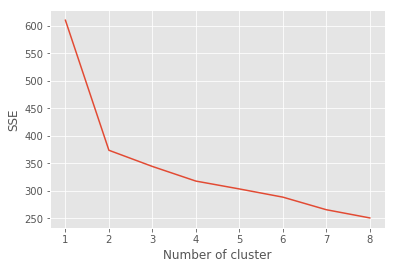

In [308]:

sse = {}
for k in range(1, 9):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_trans)
    data_trans["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [422]:
team_name = TSPG[["Team"]]
team_name["Team"] = team_name["Team"].str.replace("*", "")
team_name = team_name.reset_index().drop(["index"], axis = 1)

/Users/pydu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [441]:
team_stat = pd.concat([team_name, data_trans], axis = 1)
team_stat["clusters"] = team_stat["clusters"].astype("str")

In [399]:
#generate url list
def getUrl(year):
    baseUrl = "https://www.basketball-reference.com/leagues/NBA_"
    months = ["october", "november", "december", "january", "february", "march", "april", "may", "june"]
    urlList = []
    year += 1
    for month in months:
        urlList.append(baseUrl + str(year) + "_games-" + month + ".html")
    return urlList

In [533]:
def compareScore(score1, score2):
    result = score1 - score2
    return 1 if result > 0 else -1


In [534]:

#download html pages from urlList and parse the data
def collectAndParse(urlList):
    post = pd.DataFrame(columns=["date", "away", "awayScore", "home", "homeScore"])
    reg = []
    try:
        for url in urlList:
            #print "working on " + url
            result = requests.get(url).text
            soup = bs.BeautifulSoup(result, 'html.parser').find("table", {"id" : "schedule"}).find("tbody")
            for game in soup.find_all("tr"):
                gameDetail = {}

                gameDetail["date"] = game.find("th").get_text()

                if "Playoffs" in gameDetail["date"]:
                    reg = post
                    post = pd.DataFrame(columns=["date", "away", "awayScore", "home", "homeScore"])
                    continue

                gameDetail["away"] = game.find("td", {"data-stat" : "visitor_team_name"}).get_text()
                gameDetail["awayScore"] = int(game.find("td", {"data-stat" : "visitor_pts"}).get_text())
                gameDetail["home"] = game.find("td", {"data-stat" : "home_team_name"}).get_text()
                gameDetail["homeScore"] = int(game.find("td", {"data-stat" : "home_pts"}).get_text())
                gameDetail["result"] = compareScore(gameDetail["awayScore"], gameDetail["homeScore"])
                data = pd.Series(gameDetail)
                post = post.append(data, ignore_index = True)
    except:
        if reg == []: reg = post
        return (reg, post)
    return (reg, post)

In [535]:
def completeData(data):
    data = data[["away", "home", "result"]]
    complete_stat = data.merge(team_stat, left_on = 'away', right_on = 'Team').drop(["Team"], axis= 1)
    complete_stat = complete_stat.merge(team_stat, left_on = 'home', right_on = "Team", suffixes=["_a", "_h"]).drop(["Team"], axis = 1)
    
    X = complete_stat[list(complete_stat)[3:]]
    y = complete_stat[["result"]]
    return (complete_stat, X, y)

In [616]:
reg, post =  collectAndParse(getUrl(2017))

In [617]:
train, X_train, y_train = completeData(reg)

In [618]:
test, X_test, y_test = completeData(post)

In [619]:
X_train_copy = X_train.copy()
X_train_copy.columns = list(X_train)[15:] + list(X_train)[0:15]
y_train_copy = y_train * (-1)

In [620]:
X_train = pd.concat([X_train, X_train_copy])

In [621]:
y_train = pd.concat([y_train, y_train_copy])

In [622]:
clf = LogisticRegression(random_state=0, solver='lbfgs', \
                         multi_class='multinomial').fit(X_train, y_train)
y_predict = pd.DataFrame(clf.predict(X_test), columns=["predicted"])
y_proba = pd.DataFrame(clf.predict_proba(X_test)) 

In [612]:
y_predict

,predicted
0,1.0
1,1.0
2,-1.0
3,-1.0
4,-1.0
5,-1.0
6,-1.0
7,-1.0
8,-1.0
9,-1.0


In [613]:
y_proba

,0,1
0,0.156895,0.843105
1,0.205142,0.794858
2,0.834468,0.165532
3,0.867051,0.132949
4,0.744260,0.255740
5,0.971112,0.028888
6,0.988755,0.011245
7,0.971484,0.028516
8,0.987856,0.012144
9,0.991866,0.008134


In [614]:
confusion_matrix(y_test, y_predict)

array([[40, 11],
       [23,  8]])

In [615]:
pd.concat([post, y_predict, y_proba], axis = 1)

,date,away,awayScore,home,homeScore,result,predicted,0,1
0,"Tue, Oct 16, 2018",Philadelphia 76ers,87,Boston Celtics,105,-1.0,1.0,0.156895,0.843105
1,"Tue, Oct 16, 2018",Oklahoma City Thunder,100,Golden State Warriors,108,-1.0,1.0,0.205142,0.794858
2,"Wed, Oct 17, 2018",Milwaukee Bucks,113,Charlotte Hornets,112,1.0,-1.0,0.834468,0.165532
3,"Wed, Oct 17, 2018",Brooklyn Nets,100,Detroit Pistons,103,-1.0,-1.0,0.867051,0.132949
4,"Wed, Oct 17, 2018",New Orleans Pelicans,131,Houston Rockets,112,1.0,-1.0,0.744260,0.255740
5,"Wed, Oct 17, 2018",Memphis Grizzlies,83,Indiana Pacers,111,-1.0,-1.0,0.971112,0.028888
6,"Wed, Oct 17, 2018",Denver Nuggets,107,Los Angeles Clippers,98,1.0,-1.0,0.988755,0.011245
7,"Wed, Oct 17, 2018",Atlanta Hawks,107,New York Knicks,126,-1.0,-1.0,0.971484,0.028516
8,"Wed, Oct 17, 2018",Miami Heat,101,Orlando Magic,104,-1.0,-1.0,0.987856,0.012144
9,"Wed, Oct 17, 2018",Dallas Mavericks,100,Phoenix Suns,121,-1.0,-1.0,0.991866,0.008134


In [470]:
pd.DataFrame([y_test, y_predict], columns=["test", "predict"])

,test,predict
0,result 0 -1.0 1 -6.0 2 -11.0 3 ...,"[[-8.10942641322], [-8.10942641322], [-3.80484..."


In [ ]:
reg.score(X, y)
reg.coef_
array([1., 2.])
reg.intercept_ 
reg.predict(np.array([[3, 5]]))
array([16.])